In [26]:
from enum import Enum
from queue import PriorityQueue, LifoQueue
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Voronoi, voronoi_plot_2d
from bresenham import bresenham
from queue import Queue
import networkx as nx


%matplotlib inline 

In [ ]:
http://orensalzman.com/docs/roadmaps.pdf
http://www.cs.cmu.edu/afs/andrew/course/15/381-f08/www/lectures/motionplanning.pdf (Specially slide 6 and 7)
https://github.com/darienmt/FCND-Term1-P2-3D-Motion-Planning
https://github.com/mehmetyldz87/FCND-Motion-Planning

In [3]:
filename = './colliders.csv'
data = np.loadtxt(filename,delimiter=',',dtype='Float64',skiprows=2)
TARGET_ALTITUDE = 5
SAFETY_DISTANCE = 5

In [4]:
# minimum and maximum north coordinates
north_min = np.floor(np.min(data[:, 0] - data[:, 3]))
north_max = np.ceil(np.max(data[:, 0] + data[:, 3]))
# minimum and maximum east coordinates
east_min = np.floor(np.min(data[:, 1] - data[:, 4]))
east_max = np.ceil(np.max(data[:, 1] + data[:, 4]))
# given the minimum and maximum coordinates we can
# calculate the size of the grid.
north_size = int(np.ceil((north_max - north_min)))
east_size = int(np.ceil((east_max - east_min)))
# Initialize an empty grid
grid = np.zeros((north_size, east_size))

# Center offset for grid
north_min_center = np.min(data[:, 0])
east_min_center = np.min(data[:, 1])

In [32]:
north_min_center = np.min(data[:, 0])
east_min_center = np.min(data[:, 1])
print(north_min_center, east_min_center)

-310.2389 -439.2315


In [29]:
north_offset = int(north_min)
east_offset = int(east_min)

Objects found 3845, Point : [185.7611, 5.768500000000017]


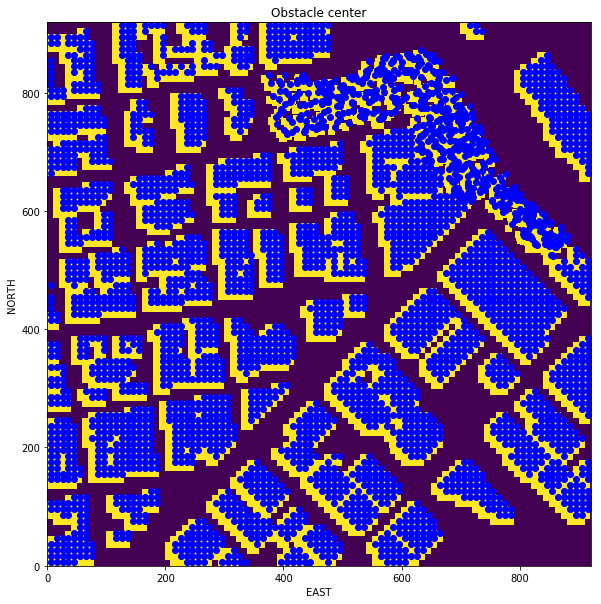

In [9]:

# Define a list to hold Voronoi points
points = []
# Populate the grid with obstacles
for i in range(data.shape[0]):
    north, east, alt, d_north, d_east, d_alt = data[i, :]
    if alt + d_alt + SAFETY_DISTANCE > TARGET_ALTITUDE:
        obstacle = [
        int(north - d_north - SAFETY_DISTANCE - north_min_center),
        int(north + d_north + SAFETY_DISTANCE - north_min_center),
        int(east - d_east - SAFETY_DISTANCE - east_min_center),
        int(east + d_east + SAFETY_DISTANCE - east_min_center),
        ]
        grid[obstacle[0]:obstacle[1], obstacle[2]:obstacle[3]] = 1

        # add center of obstacles to points list
        points.append([north - north_min, east - east_min])
 
obstacle_centers = points
print(f'Objects found {len(obstacle_centers)}, Point : {obstacle_centers[10]}')
fig = plt.figure(figsize=(20,10))
plt.imshow(grid, origin='lower') 
for north, east in obstacle_centers:
    plt.plot(east, north, 'bo')
plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.title('Obstacle center')
plt.show()

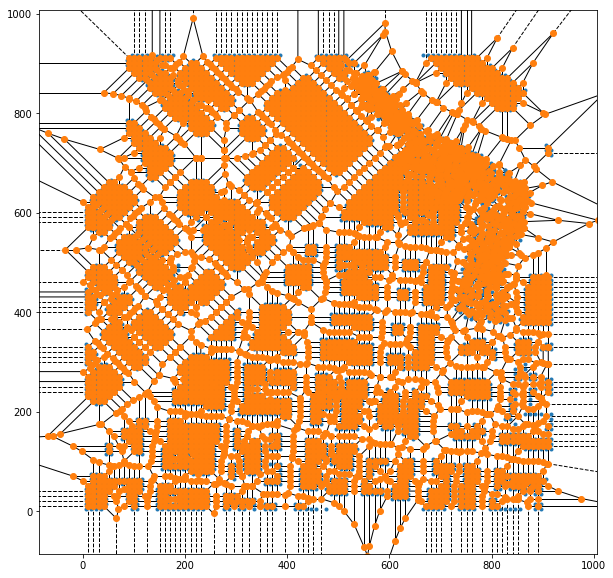

In [17]:
# TODO: create a voronoi graph based on location of obstacle centres
plt.rcParams["figure.figsize"] = [10,10]

graph = Voronoi(points)
fig = voronoi_plot_2d(graph)
plt.show()

In [20]:
# TODO: check each edge from graph.ridge_vertices for collision
edges = []
for edge in graph.ridge_vertices:
    point1 = graph.vertices[edge[0]]
    point2 = graph.vertices[edge[1]]
    cells = list(bresenham(int(point1[0]), int(point1[1]), int(point2[0]), int(point2[1])))
    infeasible = False

    for cell in cells:
        if np.amin(cell) < 0 or cell[0] >= grid.shape[0] or cell[1] >= grid.shape[1]:
            infeasible = True
            break
        if grid[cell[0], cell[1]] == 1:
            infeasible = True
            break

    if infeasible == False:
        point1 = (point1[0], point1[1])
        point2 = (point2[0], point2[1])
        edges.append((point1, point2))

Voronoi edges count: 1056


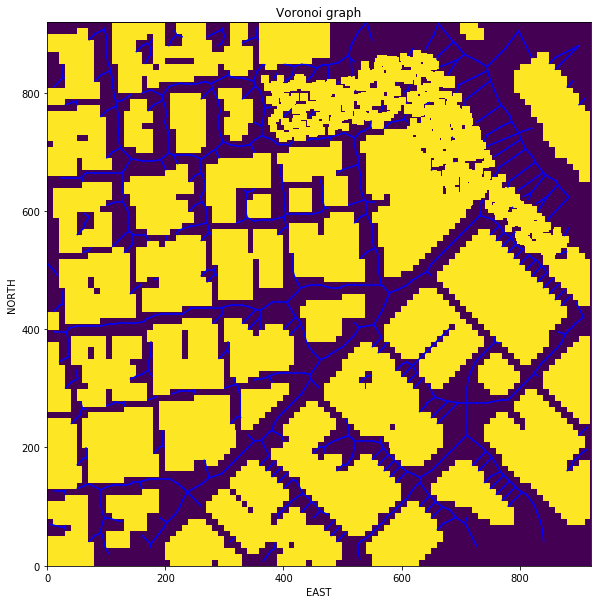

In [25]:
print(f'Voronoi edges count: {len(edges)}')
fig = plt.figure(figsize=(20,10))
plt.imshow(grid, origin='lower') 
# Stepping through each edge
for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.title('Voronoi graph')
plt.show()

Found  1056 edges


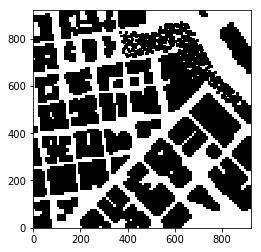

In [27]:
print('Found %5d edges' % len(edges))
plt.imshow(grid, origin='lower', cmap='Greys')

In [37]:
print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))
# Define starting point on the grid (this is just grid center)
grid_start = (-north_offset, -east_offset)
# Set goal as some arbitrary position on the grid
grid_goal = (-north_offset + 100, -east_offset + 100)

print(f"Grid Start: {grid_start}")
print(f"Grid Goal: {grid_goal}")

North offset = -316, east offset = -445
Grid Start: (316, 445)
Grid Goal: (416, 545)


In [38]:
def create_graph_from_edges(edges):
    """
    Create a graph from the `edges`
    """
    G = nx.Graph()
    for e in edges:
        p1 = e[0]
        p2 = e[1]
        dist = LA.norm(np.array(p2) - np.array(p1))
        G.add_edge(p1, p2, weight=dist)
    return G

voronoiGraph = create_graph_from_edges(edges)

In [39]:
## Since, the default center of the grid which is north and east offset (316, 345) is not necessarily a node in the
## graph we will need to readjust these offsets for both start and goal nodes by finding the nearest nodes  

def nearestNodes(graph, targetNode):
    nearestNode = None
    smallestDistance = 1e+10 #float('inf')
    for node in graph.nodes:
        distance = LA.norm(np.array(node) - np.array(targetNode))
        if distance < smallestDistance:
            nearestNode = node
            smallestDistance = distance
    return nearestNode

graphStart = nearestNodes(voronoiGraph, grid_start)
graphGoal = nearestNodes(voronoiGraph, grid_goal)
print(f"Starting Node: {graphStart}")
print(f"Target/Goal Node: {graphGoal}")

Starting Node: (315.76114, 445.76846)
Target/Goal Node: (407.79816473938746, 552.990723436202)


In [ ]:
def bfs(graph, h, start, goal):
    
    path = []
    queue = Queue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_node = item[1]
        
        if current_node == start:
            current_cost = 0.0
        else:
            current_cost = branch[current_node][0]
            
        for next_node in graph[current_node]:
                cost = graph.edges[current_node, next_node]['weight']
                branch_cost = current_cost + cost
                if next_node not in visited:                
                    visited.add(next_node)               
                    queue.put((branch_cost, next_node))
                    branch[next_node] = (branch_cost, current_node)
                if next_node == goal:        
                    print('Found a path.')
                    found = True
                    break
        if found:
            break
               
    path = []
    path_cost = 0
    if found:
        # retrace steps
        path = []
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
            
    return path[::-1], path_cost

In [ ]:
def create_grid_and_edges(data, drone_altitude, safety_distance):
    """
        Returns a grid representation of a 2D configuration space
        along with Voronoi graph edges given obstacle data and the
        drone's altitude.
    """
    # minimum and maximum north coordinates
    north_min = np.floor(np.min(data[:, 0] - data[:, 3]))
    north_max = np.ceil(np.max(data[:, 0] + data[:, 3]))
    # minimum and maximum east coordinates
    east_min = np.floor(np.min(data[:, 1] - data[:, 4]))
    east_max = np.ceil(np.max(data[:, 1] + data[:, 4]))
    # given the minimum and maximum coordinates we can
    # calculate the size of the grid.
    north_size = int(np.ceil((north_max - north_min)))
    east_size = int(np.ceil((east_max - east_min)))
    # Initialize an empty grid
    grid = np.zeros((north_size, east_size))
    # Center offset for grid
    north_min_center = np.min(data[:, 0])
    east_min_center = np.min(data[:, 1])

    # Define a list to hold Voronoi points
    points = []
    # Populate the grid with obstacles
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i, :]
        if alt + d_alt + safety_distance > drone_altitude:
            obstacle = [
            int(north - d_north - safety_distance - north_min_center),
            int(north + d_north + safety_distance - north_min_center),
            int(east - d_east - safety_distance - east_min_center),
            int(east + d_east + safety_distance - east_min_center),
            ]
            grid[obstacle[0]:obstacle[1], obstacle[2]:obstacle[3]] = 1

            # add center of obstacles to points list
            points.append([north - north_min, east - east_min])

    # TODO: create a voronoi graph based on
    # location of obstacle centres
    graph = Voronoi(points)
    # TODO: check each edge from graph.ridge_vertices for collision
    edges = []
    for edge in graph.ridge_vertices:
        point1 = graph.vertices[edge[0]]
        point2 = graph.vertices[edge[1]]
        cells = list(bresenham(int(point1[0]), int(point1[1]), int(point2[0]), int(point2[1])))
        infeasible = False

        for cell in cells:
            if np.amin(cell) < 0 or cell[0] >= grid.shape[0] or cell[1] >= grid.shape[1]:
                infeasible = True
                break
            if grid[cell[0], cell[1]] == 1:
                infeasible = True
                break

        if infeasible == False:
            point1 = (point1[0], point1[1])
            point2 = (point2[0], point2[1])
            edges.append((point1,point2))

    return grid, edges
